In [1]:
from pynhd.pynhd import NHD, NHDPlusHR, WaterData
import os, s3fs
import xarray as xr
import geopandas as gpd
import sqlalchemy as sa

from datetime import datetime

## Helper Functions for Flowline Retrieval

These are two ways to get flowlines, either from the NHD web service using HyRiver's `pynhd` package, or from our database where we've ingested the same data. The NHD web service is more portable but slower.

In [2]:
def get_flowlines_from_db(huc):
    con = sa.create_engine(
        "{driver}://{user}:{password}@{host}/{database}".format(
            driver="postgresql+psycopg2",
            user=os.getenv("PGUSER"),
            password=os.getenv("PGPASSWORD"),
            host=os.getenv("PGHOST"),
            database="nhdplusv2",
        )
    )

    sql = f"""
        SELECT comid, shape
        FROM nhdflowline_network
        WHERE ST_Intersects(
            shape,
            ST_Transform(
                ST_SetSRID(
                    ST_GeomFromText('{huc.geometry[0].wkt}'),
                    4326),
                4269)
        )
    """
    
    return gpd.GeoDataFrame.from_postgis(sql, con, geom_col='shape')

In [3]:
def get_flowlines_from_web(huc):
    return NHD('flowline_mr').bygeom(huc.geometry[0].geoms[0])

CPU times: user 576 ms, sys: 67.1 ms, total: 643 ms
Wall time: 1.92 s


<AxesSubplot:>

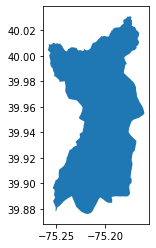

In [4]:
%%time

huc = WaterData('wbd12_20201006').byid('huc12', '020402031008')
huc.geometry.plot()

Get flowlines contained within that shape

CPU times: user 80.9 ms, sys: 37.1 ms, total: 118 ms
Wall time: 172 ms


<AxesSubplot:>

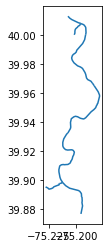

In [5]:
%%time

flowlines = get_flowlines_from_db(huc)
flowlines.plot()

Get the most recent NWM Short Term Forecast day

In [6]:
%%time

fs = s3fs.S3FileSystem(anon=True)
today = datetime.now().strftime('%Y%m%d')

netcdf_url = f's3://noaa-nwm-pds/nwm.{today}/short_range/nwm.t*z.short_range.channel_rt.*.conus.nc'
fileset = [fs.open(file) for file in fs.glob(netcdf_url)]

ds = xr.open_mfdataset(fileset, engine='h5netcdf',
                       data_vars=['streamflow'], coords='minimal', compat='override')

CPU times: user 49.9 s, sys: 6.78 s, total: 56.7 s
Wall time: 1min 51s


Subset the dataset to only the streams within the HUC. Also, pick the first forecast for the day.

In [7]:
%%time

nhd_reaches = set([int(f) for f in flowlines['comid']])
nwm_reaches = set(ds.feature_id.values)

common_reaches = list(set(nwm_reaches).intersection(set(nhd_reaches)))

CPU times: user 337 ms, sys: 28.5 ms, total: 365 ms
Wall time: 362 ms


## Pick a single feature to analyze

In [8]:
FEATURE_ID = 4784831

sub_ds = ds.sel(feature_id=[FEATURE_ID])
df = sub_ds['streamflow'].to_dataframe() #.swaplevel()
df

streamflow
reference_time      time                feature_id            
2023-01-10 00:00:00 2023-01-10 01:00:00 4784831      95.469998
                    2023-01-10 02:00:00 4784831      95.019998
                    2023-01-10 03:00:00 4784831      94.549998
                    2023-01-10 04:00:00 4784831      94.079998
                    2023-01-10 05:00:00 4784831      93.599998
...                                                        ...
2023-01-10 20:00:00 2023-01-11 10:00:00 4784831      86.749998
                    2023-01-11 11:00:00 4784831      86.969998
                    2023-01-11 12:00:00 4784831      87.239998
                    2023-01-11 13:00:00 4784831      87.559998
                    2023-01-11 14:00:00 4784831      87.909998

[798 rows x 1 columns]

<AxesSubplot:>

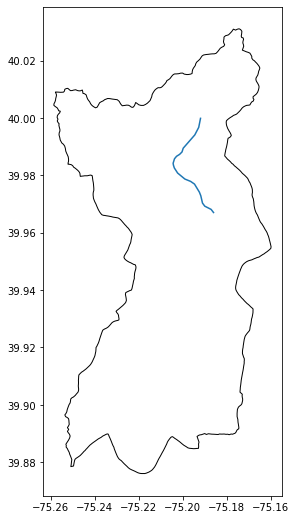

In [9]:
ax = huc.plot(facecolor="none", edgecolor="k", figsize=(9, 9))
flowlines[flowlines.comid == FEATURE_ID].plot(ax=ax)

In [10]:
sub_df = df.reset_index().drop(columns=['feature_id']).set_index(keys=['reference_time', 'time'])

### Streamflow predicted for next 18 hours at each reference time

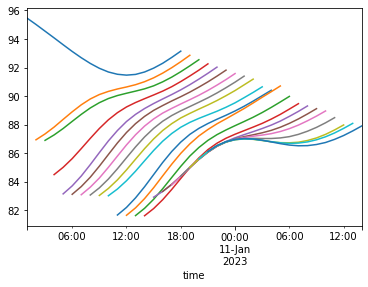

In [11]:
reference_times = list(sub_df.index.get_level_values(0).unique())
ax = sub_df.loc[reference_times[0]].plot(legend=False)
for rt in reference_times[1:]:
    sub_df.loc[rt].plot(ax=ax, legend=False)

### Change in predicted streamflow for a given time

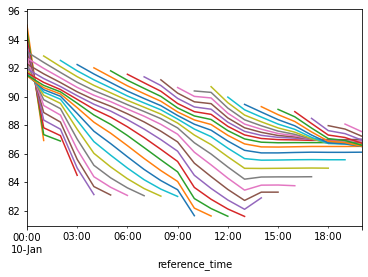

In [12]:
times = list(sub_df.index.get_level_values(1).unique())
ax = sub_df[sub_df.index.isin([times[0]], level=1)].reset_index().drop(columns=['time']).set_index(keys=['reference_time']).plot(legend=False)
for t in times[1:]:
    sub_df[sub_df.index.isin([t], level=1)].reset_index().drop(columns=['time']).set_index(keys=['reference_time']).plot(ax=ax, legend=False)

### Standard deviation of prediction by hour

<AxesSubplot:xlabel='time'>

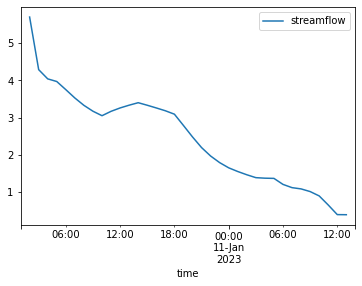

In [15]:
sub_df.groupby('time').std().plot()

### Average deviation for this reach

In [16]:
sub_df.groupby('time').std().mean()

streamflow    2.42871
dtype: float64

### Average deviation for every reach in the HUC

In [ ]:
sub_ds2 = ds.sel(feature_id=common_reaches)['streamflow']
mean_std_per_reach = sub_ds2.groupby('feature_id').std('time').mean('reference_time').to_dataframe()
mean_std_per_reach

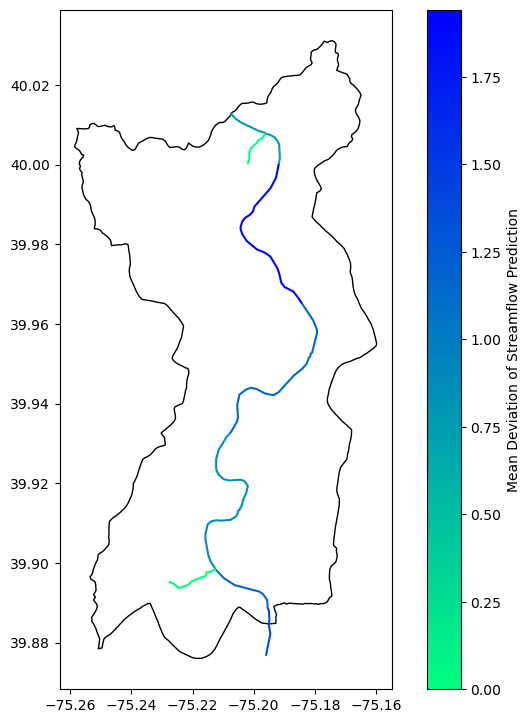

In [34]:
joined = flowlines.merge(mean_std_per_reach, left_on='comid', right_on='feature_id')

ax = huc.plot(facecolor="none", edgecolor="k", figsize=(9, 9))
joined.plot(ax=ax, column="streamflow", cmap='winter_r', legend=True, legend_kwds={"label": "Mean Deviation of Streamflow Prediction"})
ax.figure.set_dpi(100)